# **BERT - Start Up**
* Due to BERT module isn't an end-to-end package, so this is a short demonstration of how to fine-tune BERT on Google CoLab (TPU) without any feature engineering.  

In [10]:
train_df.head(5)

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


In [11]:
test_df.head(5)

,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


# Short Demo of BERT
* https://huggingface.co/
* https://clay-atlas.com/blog/2020/06/30/pytorch-%E5%A6%82%E4%BD%95%E4%BD%BF%E7%94%A8-hugging-face-%E6%89%80%E6%8F%90%E4%BE%9B%E7%9A%84-transformers-%E4%BB%A5-bert-%E7%82%BA%E4%BE%8B/

In [ ]:
!pip install transformers -q

#### Type1 : tokenizer.encode()

In [ ]:
# coding: utf-8
import torch
from transformers import AutoTokenizer, AutoModel
from keras.preprocessing.sequence import pad_sequences

# Tokenizer and Bert Model
tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')
embedding = AutoModel.from_pretrained('bert-base-chinese')

In [ ]:
# Preprocess
sent = '今天天氣真 Good。'
sent_token = tokenizer.encode(sent) #把句子送到Tokenizer裡面編碼
sent_token_padding = pad_sequences([sent_token], maxlen=10, padding='post', dtype='int')
masks = [[float(value>0) for value in values] for values in sent_token_padding]

print('sent:', sent)
print('sent_token:', sent_token)
print('sent_token_padding:', sent_token_padding)
print('masks:', masks)
print('\n')


# Convert
inputs = torch.tensor(sent_token_padding)
masks = torch.tensor(masks)
embedded, _ = embedding(inputs, attention_mask=masks)
print('embedded shape:', embedded.shape)

#### Type 2: convert_token_to_ids()

In [ ]:
# coding: utf-8
import torch
from transformers import AutoTokenizer, AutoModel
from keras.preprocessing.sequence import pad_sequences

MODEL = 'jplu/tf-xlm-roberta-large' # bert-base-multilingual-uncased

# Tokenizer and Bert Model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
sent = '今天天氣真 Good。'
sent_token = ['[CLS]'] + tokenizer.tokenize(sent) + ['[SEP]']
sent_token

In [ ]:
sent_token_encode = tokenizer.convert_tokens_to_ids(sent_token)
sent_token_decode = tokenizer.convert_ids_to_tokens(sent_token_encode)

print('encode:', sent_token_encode)
print('decode:', sent_token_decode)

# Fine Tune

In [7]:
!pip install transformers -q

     |████████████████████████████████| 890kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 17.5MB/s 
     |████████████████████████████████| 890kB 26.0MB/s 
     |████████████████████████████████| 3.0MB 17.2MB/s 


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import torch
from keras.preprocessing.sequence import pad_sequences

import transformers
from transformers import TFAutoModel, AutoTokenizer, AutoConfig, AutoModel
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

import numpy as np

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.3.0


#### Check TPU 

In [9]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.23.34.122:8470


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.23.34.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.23.34.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


#### download model from hugging face

In [13]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 2 #Ethan:建議3~5,6以上很容易overfit,樣本太少
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
MODEL = 'google/mobilebert-uncased'

#Other models you can use:
#'jplu/tf-xlm-roberta-large' # bert-base-multilingual-uncased #jplu/tf-xlm-roberta-large

In [14]:
# Tokenizer and Bert Model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

#### Define Funciton

In [15]:
def regular_encode(texts, tokenizer, maxlen=128):
    enc_di = tokenizer.batch_encode_plus(
             texts, 
             return_attention_masks=False, 
             return_token_type_ids=False,
             pad_to_max_length=True,
             max_length=maxlen)
    
    return np.array(enc_di['input_ids'])

In [16]:
def build_model(transformer, max_len=128):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(5, activation='softmax')(cls_token) # 5 ratings to predict
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

#### Train-test split

In [17]:
# since tf.keras reads your data take 0 as the reference, our category should start from 0 not 1
rating_mapper_encode = {1: 0,
                        2: 1,
                        3: 2,
                        4: 3,
                        5: 4}

# convert back to original rating after prediction later(dont forget!!)
rating_mapper_decode = {0: 1,
                        1: 2,
                        2: 3,
                        3: 4,
                        4: 5}

train_df['rating'] = train_df['rating'].map(rating_mapper_encode)

In [18]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(train_df['rating'], num_classes=5)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.15,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((124789,), (22022,), (124789, 5), (22022, 5))

In [ ]:
# config = AutoConfig.from_pretrained(MODEL, output_hidden_states=True)
# transformer_layer = TFAutoModel.from_pretrained(MODEL, config = config)

#### Sub dataset to demonstrate how to use BERT...

In [20]:
Sub_size = 1000

In [23]:
X_train

124782                                        Nice, very ok
62278     Is OK number for large bags to be much money b...
126890     Excellent product quality excellent product p...
112079    Fix order please fill in the form Full name : ...
26264     Initially it's happy because his bold charge f...
                                ...                        
135149    Excellent quality very accommodating seller we...
107086    Order of the day Saturday was a very sensitive...
120910                                 Good product quality
516       The price does not match the number of the goo...
1088      The pattern is not the same with pictures Diff...
Name: review, Length: 124789, dtype: object

In [24]:
X_train = X_train[0:Sub_size]
X_train

124782                                        Nice, very ok
62278     Is OK number for large bags to be much money b...
126890     Excellent product quality excellent product p...
112079    Fix order please fill in the form Full name : ...
26264     Initially it's happy because his bold charge f...
                                ...                        
67763      The product quality is excellent. The origina...
131464     Excellent product quality product packaging i...
86667     cakeppp really oath dressnya .. thanks once cr...
120681    Alhamdulillah goods arrive safely Good stuff a...
130592    Middling stuff cool .. Fast shipping ... Price...
Name: review, Length: 1000, dtype: object

In [25]:
X_train.values

array(['Nice, very ok',
       'Is OK number for large bags to be much money but I put black Sp which delivered white shop shop disappointed hope more attention when the pillow, customers',
       ' Excellent product quality excellent product price is very good delivery speed response sangatbaik seller, Packing very neat .. Success continues',
       'Fix order please fill in the form Full name : address: School : The goods ordered:',
       "Initially it's happy because his bold charge fairly quickly. But unfortunately, after 2 weeks of use, suddenly broken. I wondered hp sempet I damaged because gabisa in charge. It turns faulty charger port. Gatau does no warranty or her engga.",
       '1 bit thick surface is k hook is so new right hand just how thin or small severance',
       'Commanded shop delivered back to the wrong sample color unthinkably Interior steam vonggggggg',
       'Until the product really old but so far like the color even though the smell of jasmine',
       'Dn s

In [27]:
MAX_LEN = 128

In [28]:
X_train = regular_encode(X_train.values, tokenizer, maxlen=MAX_LEN)
X_train

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_att

array([[  101,  3835,  1010, ...,     0,     0,     0],
       [  101,  2003,  7929, ...,     0,     0,     0],
       [  101,  6581,  4031, ...,     0,     0,     0],
       ...,
       [  101,  9850,  9397, ...,     0,     0,     0],
       [  101,  2632,  3511, ...,     0,     0,     0],
       [  101,  3054, 14423, ...,     0,     0,     0]])

In [30]:
y_train = y_train[0:Sub_size]
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [31]:
X_val = regular_encode(X_val.values[0:Sub_size], tokenizer, maxlen=MAX_LEN)
X_val

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_att

array([[  101, 15708, 14793, ...,     0,     0,     0],
       [  101, 17917,  6190, ...,     0,     0,     0],
       [  101, 16853,  2015, ...,     0,     0,     0],
       ...,
       [  101,  4031,  3737, ...,     0,     0,     0],
       [  101,  1996,  4031, ...,     0,     0,     0],
       [  101,  6581,  4031, ...,     0,     0,     0]])

In [32]:
y_val = y_val[0:Sub_size]
y_val

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [33]:
X_test = regular_encode(test_df['review'].values[0:Sub_size-300], tokenizer, maxlen=MAX_LEN)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_att

#### 批次進行BERT tokenizer(not necessary)

In [ ]:
#use BERT tokenizer to encode data
chunk_size = 300

In [ ]:
X_train.values[0:chunk_size] == X_train_chunks[0]

124782    True
62278     True
126890    True
112079    True
26264     True
          ... 
70338     True
109751    True
131033    True
13527     True
36548     True
Name: review, Length: 300, dtype: bool

In [ ]:
#testing
X_train_test = regular_encode(X_train_chunks[0], tokenizer, maxlen=MAX_LEN)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_att

In [ ]:
X_train_chunks = [X_train[i:i+chunk_size] for i in range(0, X_train.shape[0], chunk_size)]

In [ ]:
#Crash!!
cnt=0
for chunk_i in tqdm(range(len(X_train_chunks))):
  if cnt==0:
    init_tokens = regular_encode(X_train_chunks[chunk_i], tokenizer, maxlen=MAX_LEN)
    cnt+=1
  else:
    tmp_tokens = regular_encode(X_train_chunks[chunk_i], tokenizer, maxlen=MAX_LEN)
    init_tokens = np.concatenate((init_tokens,tmp_tokens),axis=0)

X_train = init_tokens

串流輸出內容已截斷至最後 5000 行。
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_

#### Tensorflow dataset

In [34]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

In [35]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing TFMobileBertModel: ['predictions___cls', 'seq_relationship___cls']
- This IS expected if you are initializing TFMobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFMobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFMobileBertModel were initialized from the model checkpoint at google/mobilebert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMobileBertModel for predictions without further training.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_mobile_bert_model (TFMobi ((None, 128, 512), (None, 24581888  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 24,584,453
Trainable params: 24,584,453
Non-trainable params: 0
_________________________________________________________________
CPU times: user 41.2 s, sys: 8.84 s, total: 50 s
Wall time: 56.2 s


In [36]:
%%time
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/2
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 2/15 [===>..........................] - ETA: 1:14:57 - loss: 30621028.0000 - accuracy: 0.1250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0437s vs `on_train_batch_end` time: 0.1681s). Check your callbacks.


15/15 [==============================] - ETA: 0s - loss: 8287975.0000 - accuracy: 0.1135 WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0130s vs `on_test_batch_end` time: 0.0511s). Check your callbacks.


15/15 [==============================] - 745s 50s/step - loss: 8287975.0000 - accuracy: 0.1135 - val_loss: 408202.9062 - val_accuracy: 0.1100
Epoch 2/2
15/15 [==============================] - 5s 329ms/step - loss: 23102.3789 - accuracy: 0.1948 - val_loss: 193176.0469 - val_accuracy: 0.2520
CPU times: user 2min 23s, sys: 10.4 s, total: 2min 33s
Wall time: 15min 8s


#### Let's see how we get on loss!

In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

plt.rcParams['figure.figsize'] = [14, 8]

pd.set_option('display.max_colwidth', -1)

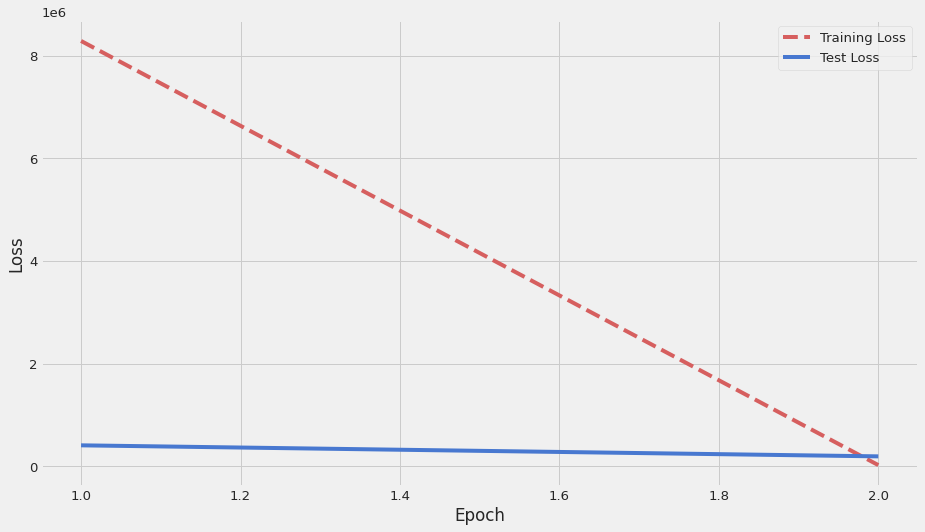

In [40]:
plt.style.use('fivethirtyeight')

# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Prediction

In [41]:
#test data prediction
pred = model.predict(test_dataset, verbose=1)

 2/11 [====>.........................] - ETA: 1:27WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0123s vs `on_predict_batch_end` time: 0.0480s). Check your callbacks.


11/11 [==============================] - 20s 2s/step


In [42]:
pred

array([[2.30209665e-08, 1.64245739e-06, 9.90220129e-01, 9.28914361e-03,
        4.89003607e-04],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [4.42141697e-07, 2.56515636e-06, 8.82444203e-01, 1.16196319e-01,
        1.35643070e-03],
       ...,
       [5.32033891e-06, 1.08441418e-06, 9.90730584e-01, 8.82845931e-03,
        4.34617396e-04],
       [1.50158291e-06, 2.60222942e-06, 9.88556087e-01, 1.12457415e-02,
        1.94096094e-04],
       [2.12040128e-08, 2.81036068e-06, 9.74356830e-01, 2.30911504e-02,
        2.54931115e-03]], dtype=float32)